<a href="https://colab.research.google.com/github/saeed-art/BR_001/blob/main/notebooks/SAM2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Jul  6 21:08:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 32.46 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.

In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.4/837.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
# Download latest SAM 2.1 model checkpoints (September 2024)
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
# make data folder at home directory
!mkdir -p {HOME}/data

In [20]:
# Download example images
"""
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
"""

SyntaxError: incomplete input (ipython-input-20-2887278577.py, line 2)

In [7]:
# Download images from Google Drive - Simple Method
from google.colab import drive
import os
import shutil

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create data directory
!mkdir -p {HOME}/data

# CHANGE THIS PATH to your specific Google Drive folder
DRIVE_FOLDER = "/content/drive/MyDrive/data_bridge"  # <<<< UPDATE THIS PATH

# Check if folder exists
if os.path.exists(DRIVE_FOLDER):
    # Get all files in the specified folder only
    files = os.listdir(DRIVE_FOLDER)
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

    # Copy each image file
    for i, img_file in enumerate(image_files):
        source = os.path.join(DRIVE_FOLDER, img_file)
        destination = os.path.join(f"{HOME}/data", img_file)

        # Only copy if it's a file (not a folder)
        if os.path.isfile(source):
            shutil.copy2(source, destination)
            print(f"Copied: {img_file}")

Mounting Google Drive...
Mounted at /content/drive
Copied: rgb_00000.png
Copied: rgb_00001.png
Copied: rgb_00002.png
Copied: rgb_00009.png
Copied: rgb_00010.png
Copied: rgb_00011.png
Copied: rgb_00013.png
Copied: rgb_00014.png
Copied: rgb_00015.png
Copied: rgb_00016.png
Copied: rgb_00018.png
Copied: rgb_00019.png
Copied: rgb_00022.png
Copied: rgb_00023.png
Copied: rgb_00028.png
Copied: rgb_00029.png
Copied: rgb_00031.png
Copied: rgb_00034.png
Copied: rgb_00038.png
Copied: rgb_00039.png
Copied: rgb_00044.png
Copied: rgb_00046.png
Copied: rgb_00048.png
Copied: rgb_00049.png
Copied: rgb_00053.png
Copied: rgb_00055.png
Copied: rgb_00061.png
Copied: rgb_00064.png
Copied: rgb_00073.png
Copied: rgb_00078.png
Copied: rgb_00081.png
Copied: rgb_00085.png
Copied: rgb_00091.png
Copied: rgb_00092.png
Copied: rgb_00098.png
Copied: rgb_00102.png
Copied: rgb_00103.png
Copied: rgb_00106.png
Copied: rgb_00108.png
Copied: rgb_00109.png
Copied: rgb_00110.png
Copied: rgb_00117.png
Copied: rgb_00118.png
Cop

### Imports

In [8]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [9]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [10]:
# Model configuration for SAM 2.1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_large.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

# Load the SAM 2.1 model
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [11]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

**NOTE:** OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

In [12]:
IMAGE_PATH = f"{HOME}/data/rgb_00010.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

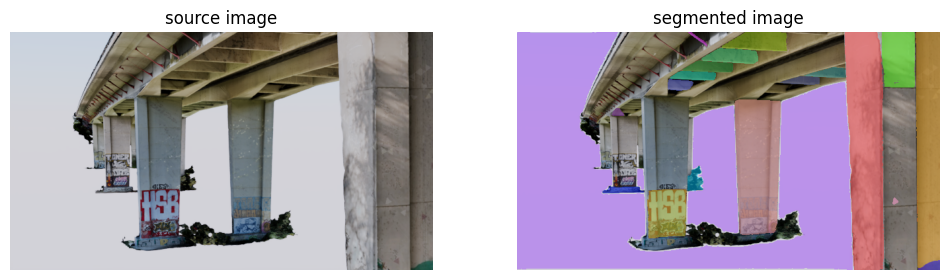

In [13]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

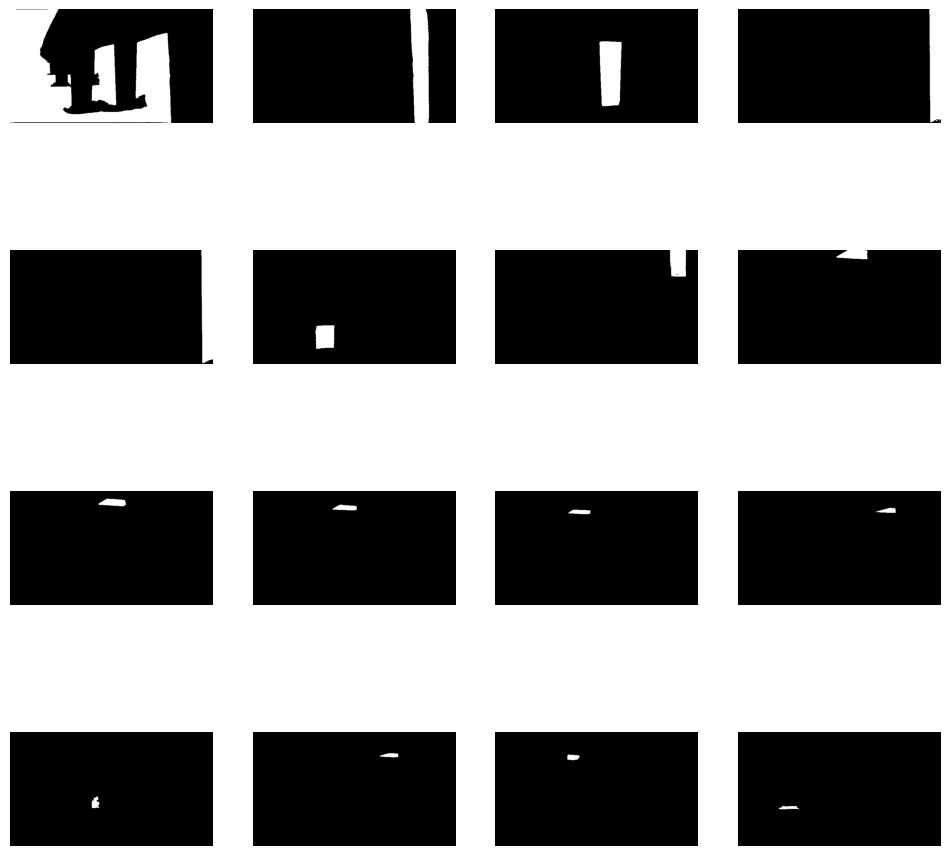

In [14]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [15]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [16]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

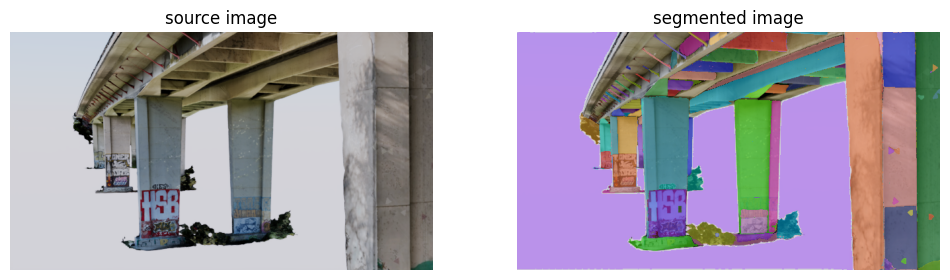

In [17]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Batch Seg

In [18]:
import os
import glob
from tqdm import tqdm
import time

def process_batch_images(input_folder, output_folder=None, image_extensions=['*.jpg', '*.jpeg', '*.png', '*.bmp']):

    # Setup output folder
    if output_folder is None:
        output_folder = f"{HOME}/batch_results"

    os.makedirs(output_folder, exist_ok=True)

    # Find all image files
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))
        image_files.extend(glob.glob(os.path.join(input_folder, ext.upper())))

    print(f"Found {len(image_files)} images to process")

    if len(image_files) == 0:
        print(f"No images found in {input_folder}")
        return {}

    # Process each image
    results = []
    total_start_time = time.time()

    for i, image_path in enumerate(tqdm(image_files, desc="Processing images")):
        try:
            start_time = time.time()

            # Load image
            image_bgr = cv2.imread(image_path)
            if image_bgr is None:
                print(f"Warning: Could not load {image_path}")
                continue

            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            # Generate masks
            sam_result = mask_generator.generate(image_rgb)   # first mask generator - faster

            # Calculate processing time
            processing_time = time.time() - start_time

            # Save results
            image_name = os.path.splitext(os.path.basename(image_path))[0]

            # Create annotated image
            mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
            detections = sv.Detections.from_sam(sam_result=sam_result)
            annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

            # Save annotated image
            output_path = os.path.join(output_folder, f"{image_name}_segmented.png")
            cv2.imwrite(output_path, annotated_image)

            # Store results
            result = {
                'path': image_path,
                'image_name': image_name,
                'num_masks': len(sam_result),
                'processing_time': processing_time,
                'output_path': output_path,
                'masks': sam_result
            }
            results.append(result)

            print(f"Processed {image_name}: {len(sam_result)} masks in {processing_time:.2f}s")

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    total_time = time.time() - total_start_time

    # Summary statistics
    if results:
        avg_masks = sum(r['num_masks'] for r in results) / len(results)
        avg_time = sum(r['processing_time'] for r in results) / len(results)

        print(f"\n=== Batch Processing Complete ===")
        print(f"Processed: {len(results)}/{len(image_files)} images")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average masks per image: {avg_masks:.1f}")
        print(f"Average processing time: {avg_time:.2f} seconds per image")
        print(f"Results saved to: {output_folder}")

    return {
        'results': results,
        'summary': {
            'total_images': len(image_files),
            'processed_images': len(results),
            'total_time': total_time,
            'avg_masks': avg_masks if results else 0,
            'avg_time': avg_time if results else 0,
            'output_folder': output_folder
        }
    }

# Run batch processing on your data folder
INPUT_FOLDER = f"{HOME}/data"  # Folder containing your images
OUTPUT_FOLDER = f"{HOME}/batch_results"  # Where to save results

print("Starting batch processing...")
batch_results = process_batch_images(INPUT_FOLDER, OUTPUT_FOLDER)

Starting batch processing...
Found 44 images to process


Processing images:   2%|▏         | 1/44 [00:06<04:32,  6.34s/it]

Processed rgb_00031: 5 masks in 6.32s


Processing images:   5%|▍         | 2/44 [00:11<04:01,  5.76s/it]

Processed rgb_00092: 6 masks in 5.33s


Processing images:   7%|▋         | 3/44 [00:17<03:57,  5.80s/it]

Processed rgb_00119: 3 masks in 5.84s


Processing images:   9%|▉         | 4/44 [00:23<03:53,  5.83s/it]

Processed rgb_00103: 16 masks in 5.85s


Processing images:  11%|█▏        | 5/44 [00:28<03:43,  5.73s/it]

Processed rgb_00029: 5 masks in 5.53s


Processing images:  14%|█▎        | 6/44 [00:34<03:39,  5.77s/it]

Processed rgb_00023: 12 masks in 5.80s


Processing images:  16%|█▌        | 7/44 [00:40<03:35,  5.83s/it]

Processed rgb_00064: 9 masks in 5.92s


Processing images:  18%|█▊        | 8/44 [00:46<03:26,  5.74s/it]

Processed rgb_00108: 37 masks in 5.50s


Processing images:  20%|██        | 9/44 [00:51<03:18,  5.67s/it]

Processed rgb_00109: 40 masks in 5.46s


Processing images:  23%|██▎       | 10/44 [00:57<03:10,  5.59s/it]

Processed rgb_00081: 11 masks in 5.41s


Processing images:  25%|██▌       | 11/44 [01:02<03:05,  5.62s/it]

Processed rgb_00015: 26 masks in 5.63s


Processing images:  27%|██▋       | 12/44 [01:09<03:07,  5.87s/it]

Processed rgb_00022: 9 masks in 6.43s


Processing images:  30%|██▉       | 13/44 [01:14<02:59,  5.78s/it]

Processed rgb_00055: 25 masks in 5.54s


Processing images:  32%|███▏      | 14/44 [01:20<02:52,  5.75s/it]

Processed rgb_00053: 23 masks in 5.63s


Processing images:  34%|███▍      | 15/44 [01:26<02:49,  5.86s/it]

Processed rgb_00078: 11 masks in 6.08s


Processing images:  36%|███▋      | 16/44 [01:32<02:42,  5.79s/it]

Processed rgb_00039: 14 masks in 5.61s


Processing images:  39%|███▊      | 17/44 [01:37<02:34,  5.74s/it]

Processed rgb_00018: 11 masks in 5.57s


Processing images:  41%|████      | 18/44 [01:43<02:30,  5.79s/it]

Processed rgb_00048: 20 masks in 5.89s


Processing images:  43%|████▎     | 19/44 [01:49<02:22,  5.70s/it]

Processed rgb_00110: 26 masks in 5.44s


Processing images:  45%|████▌     | 20/44 [01:55<02:16,  5.70s/it]

Processed rgb_00061: 18 masks in 5.65s


Processing images:  48%|████▊     | 21/44 [02:01<02:14,  5.85s/it]

Processed rgb_00013: 8 masks in 6.18s


Processing images:  50%|█████     | 22/44 [02:07<02:10,  5.95s/it]

Processed rgb_00049: 17 masks in 6.17s


Processing images:  52%|█████▏    | 23/44 [02:13<02:08,  6.11s/it]

Processed rgb_00034: 3 masks in 6.46s


Processing images:  55%|█████▍    | 24/44 [02:20<02:01,  6.10s/it]

Processed rgb_00002: 28 masks in 6.02s


Processing images:  57%|█████▋    | 25/44 [02:25<01:55,  6.06s/it]

Processed rgb_00102: 9 masks in 5.97s


Processing images:  59%|█████▉    | 26/44 [02:32<01:50,  6.14s/it]

Processed rgb_00011: 15 masks in 6.28s


Processing images:  61%|██████▏   | 27/44 [02:38<01:42,  6.04s/it]

Processed rgb_00014: 13 masks in 5.80s


Processing images:  64%|██████▎   | 28/44 [02:43<01:34,  5.93s/it]

Processed rgb_00046: 19 masks in 5.64s


Processing images:  66%|██████▌   | 29/44 [02:49<01:27,  5.84s/it]

Processed rgb_00000: 22 masks in 5.58s


Processing images:  68%|██████▊   | 30/44 [02:54<01:19,  5.69s/it]

Processed rgb_00073: 15 masks in 5.31s


Processing images:  70%|███████   | 31/44 [03:00<01:13,  5.69s/it]

Processed rgb_00118: 8 masks in 5.68s


Processing images:  73%|███████▎  | 32/44 [03:06<01:10,  5.87s/it]

Processed rgb_00085: 7 masks in 6.26s


Processing images:  75%|███████▌  | 33/44 [03:12<01:03,  5.75s/it]

Processed rgb_00001: 27 masks in 5.43s


Processing images:  77%|███████▋  | 34/44 [03:17<00:56,  5.65s/it]

Processed rgb_00028: 10 masks in 5.40s


Processing images:  80%|███████▉  | 35/44 [03:23<00:50,  5.65s/it]

Processed rgb_00091: 10 masks in 5.63s


Processing images:  82%|████████▏ | 36/44 [03:29<00:45,  5.72s/it]

Processed rgb_00098: 7 masks in 5.85s


Processing images:  84%|████████▍ | 37/44 [03:34<00:40,  5.72s/it]

Processed rgb_00117: 20 masks in 5.70s


Processing images:  86%|████████▋ | 38/44 [03:40<00:34,  5.73s/it]

Processed rgb_00010: 20 masks in 5.72s


Processing images:  89%|████████▊ | 39/44 [03:46<00:28,  5.75s/it]

Processed rgb_00009: 23 masks in 5.72s


Processing images:  91%|█████████ | 40/44 [03:52<00:23,  5.89s/it]

Processed rgb_00044: 9 masks in 6.17s


Processing images:  93%|█████████▎| 41/44 [03:58<00:17,  5.94s/it]

Processed rgb_00016: 19 masks in 6.02s


Processing images:  95%|█████████▌| 42/44 [04:04<00:11,  5.84s/it]

Processed rgb_00019: 14 masks in 5.59s


Processing images:  98%|█████████▊| 43/44 [04:10<00:05,  5.88s/it]

Processed rgb_00106: 14 masks in 5.94s


Processing images: 100%|██████████| 44/44 [04:15<00:00,  5.81s/it]

Processed rgb_00038: 10 masks in 5.41s

=== Batch Processing Complete ===
Processed: 44/44 images
Total time: 255.72 seconds
Average masks per image: 15.3
Average processing time: 5.78 seconds per image
Results saved to: /content/batch_results


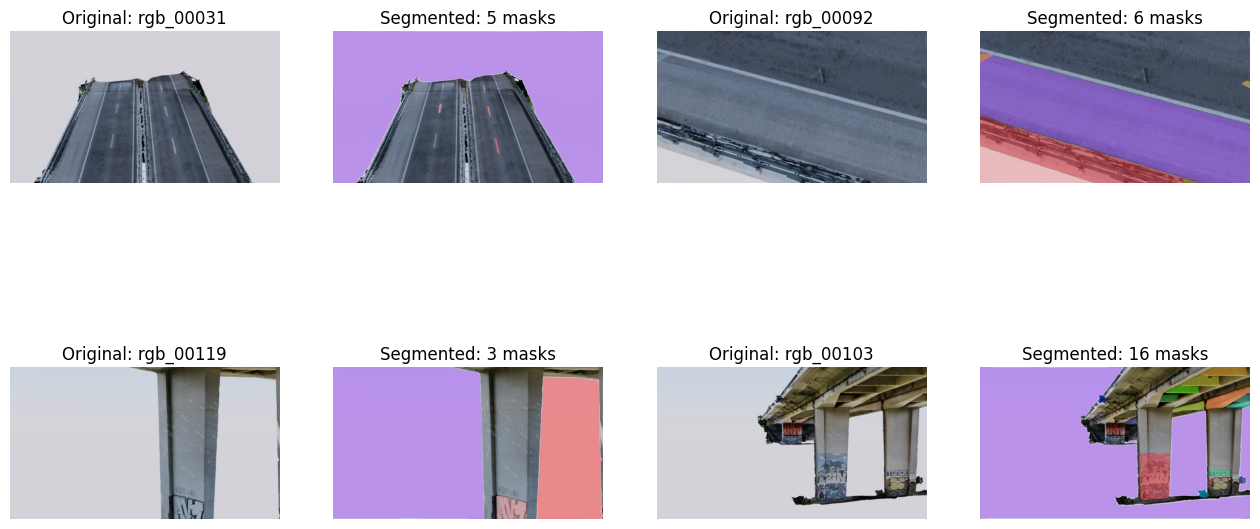


=== Batch Processing Summary ===
Total images found: 44
Successfully processed: 44
Average masks per image: 15.3
Average processing time: 5.78 seconds
Total processing time: 255.72 seconds


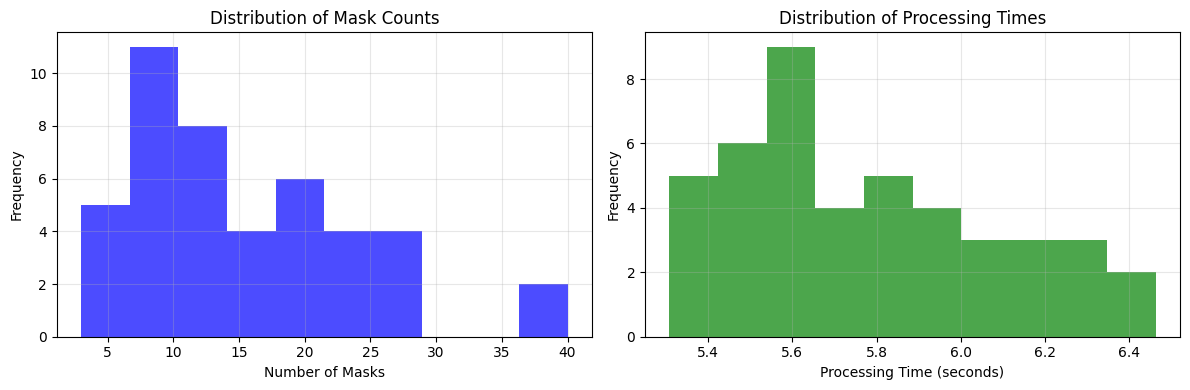

In [72]:
# Visualize batch processing results
def visualize_batch_results(batch_results, max_display=6):

    if not batch_results or 'results' not in batch_results:
        print("No batch results to visualize")
        return

    results = batch_results['results']

    if len(results) == 0:
        print("No processed images to display")
        return

    # Display first few results
    display_results = results[:max_display]

    # Create grid of original and segmented images
    images_to_show = []
    titles = []

    for result in display_results:
        # Load original image
        original_img = cv2.imread(result['path'])
        # Load segmented image
        segmented_img = cv2.imread(result['output_path'])

        images_to_show.extend([original_img, segmented_img])
        titles.extend([
            f"Original: {result['image_name']}",
            f"Segmented: {result['num_masks']} masks"
        ])

    # Calculate grid size
    n_pairs = len(display_results)
    grid_cols = 4  # 2 images per result * 2 columns
    grid_rows = max(1, (n_pairs + 1) // 2)

    if len(images_to_show) > 0:
        sv.plot_images_grid(
            images=images_to_show,
            grid_size=(grid_rows, grid_cols),
            titles=titles,
            size=(16, 4 * grid_rows)
        )

    # Print summary statistics
    summary = batch_results['summary']
    print(f"\n=== Batch Processing Summary ===")
    print(f"Total images found: {summary['total_images']}")
    print(f"Successfully processed: {summary['processed_images']}")
    print(f"Average masks per image: {summary['avg_masks']:.1f}")
    print(f"Average processing time: {summary['avg_time']:.2f} seconds")
    print(f"Total processing time: {summary['total_time']:.2f} seconds")

    # Show mask count distribution
    if results:
        mask_counts = [r['num_masks'] for r in results]
        processing_times = [r['processing_time'] for r in results]

        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Mask count histogram
        ax1.hist(mask_counts, bins=10, alpha=0.7, color='blue')
        ax1.set_xlabel('Number of Masks')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Mask Counts')
        ax1.grid(True, alpha=0.3)

        # Processing time histogram
        ax2.hist(processing_times, bins=10, alpha=0.7, color='green')
        ax2.set_xlabel('Processing Time (seconds)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Processing Times')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Visualize the batch results
if 'batch_results' in locals() and batch_results:
    visualize_batch_results(batch_results, max_display=4)
else:
    print("Run the batch processing cell first to generate results")

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [27]:
predictor = SAM2ImagePredictor(sam2_model)

In [29]:
IMAGE_PATH = f"{HOME}/data/rgb_00013.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Interactive box prompt

In [30]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [59]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [60]:
widget.bboxes

[{'x': 110, 'y': 32, 'width': 168, 'height': 178, 'label': ''},
 {'x': 254, 'y': 0, 'width': 187, 'height': 91, 'label': ''},
 {'x': 0, 'y': 48, 'width': 38, 'height': 162, 'label': ''},
 {'x': 1, 'y': 0, 'width': 124, 'height': 68, 'label': ''}]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [61]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [64]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)


### Results visualisation

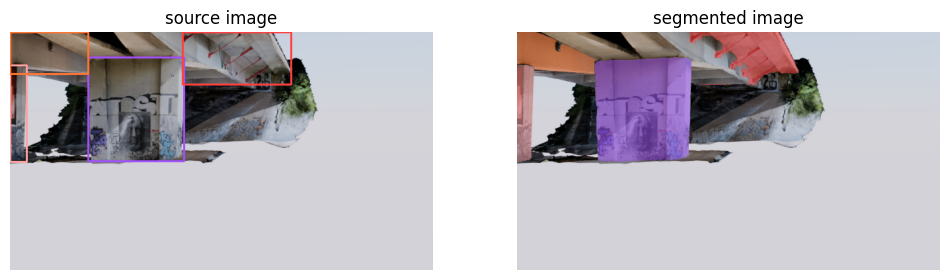

In [65]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [66]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [67]:
widget.bboxes

[{'x': 145, 'y': 68, 'width': 0, 'height': 0, 'label': ''},
 {'x': 202, 'y': 65, 'width': 1, 'height': 0, 'label': ''},
 {'x': 238, 'y': 88, 'width': 0, 'height': 0, 'label': ''},
 {'x': 210, 'y': 122, 'width': 0, 'height': 0, 'label': ''},
 {'x': 134, 'y': 161, 'width': 0, 'height': 0, 'label': ''},
 {'x': 234, 'y': 175, 'width': 0, 'height': 0, 'label': ''},
 {'x': 191, 'y': 156, 'width': 0, 'height': 0, 'label': ''}]

In [68]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [69]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False, #change to true if you want the other two predictions with lower score
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

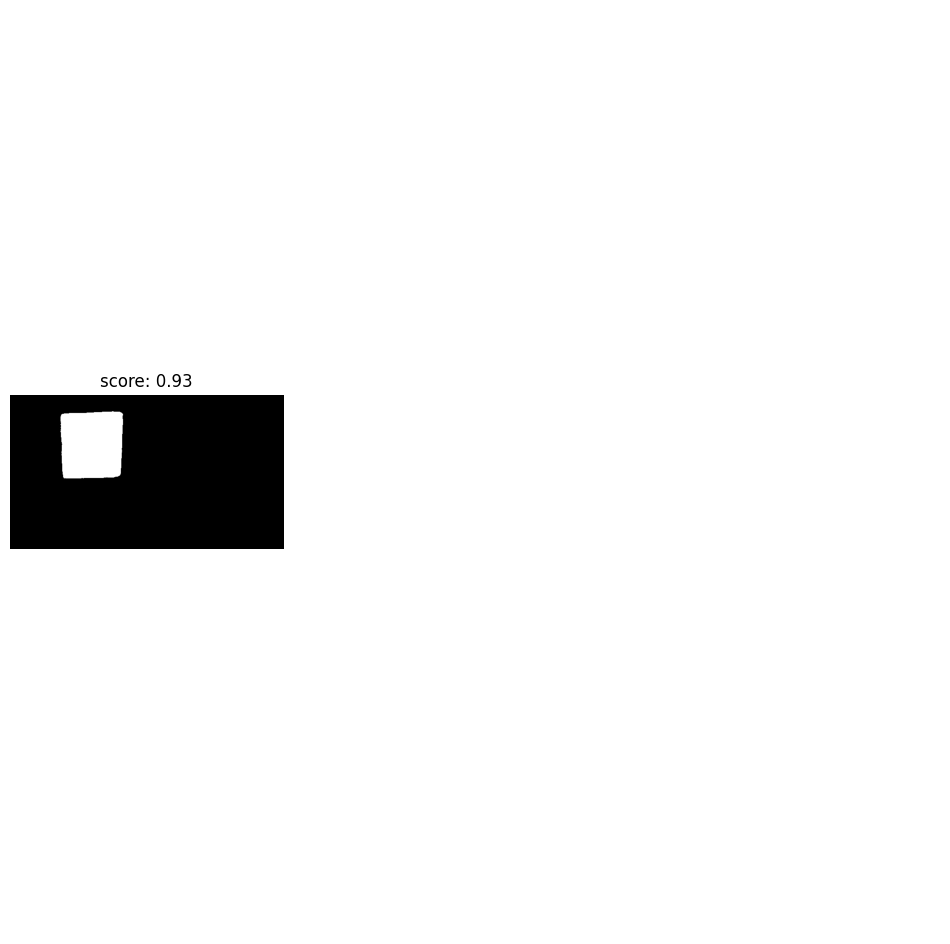

In [70]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)

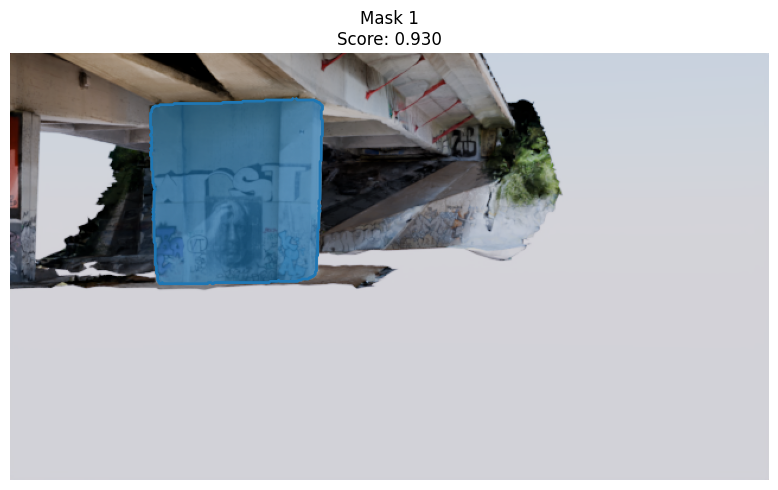

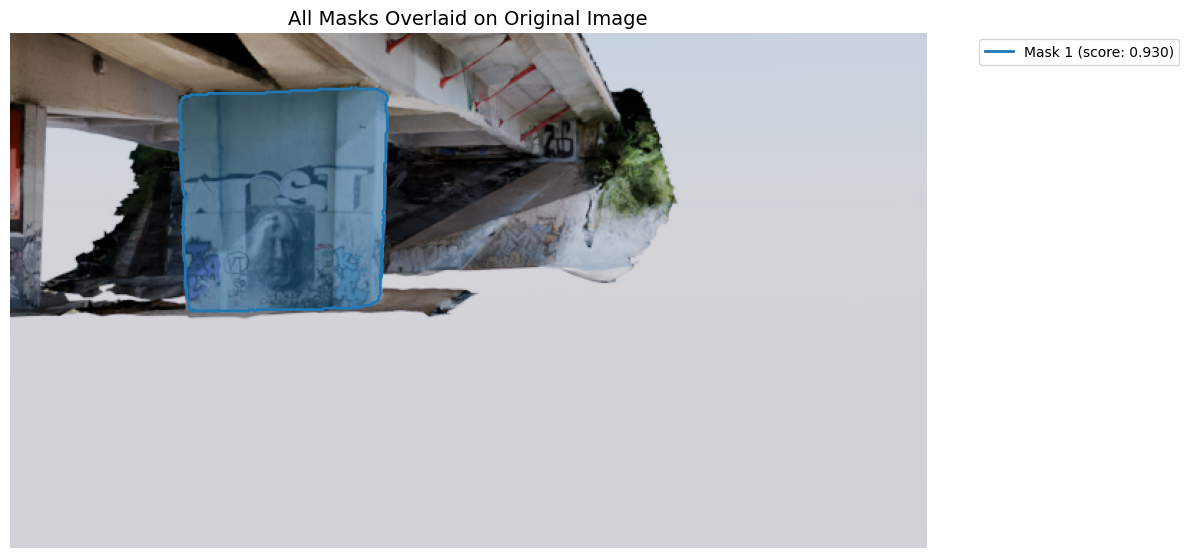

In [71]:
# Show masks overlaid on original image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(masks), figsize=(15, 5))

# If only one mask, make axes a list for consistency
if len(masks) == 1:
    axes = [axes]

for i, (mask, score) in enumerate(zip(masks, scores)):
    # Create colored mask overlay
    mask_color = plt.cm.tab10(i)[:3]  # Get different color for each mask
    mask_rgba = np.zeros((*mask.shape, 4))
    mask_bool = mask.astype(bool)  # Convert to boolean for indexing
    mask_rgba[mask_bool] = [*mask_color, 0.6]  # Semi-transparent colored mask

    # Show original image
    axes[i].imshow(image_rgb)

    # Overlay mask
    axes[i].imshow(mask_rgba)

    # Add title with score
    score_value = score.item() if hasattr(score, 'item') else float(score)
    axes[i].set_title(f"Mask {i+1}\nScore: {score_value:.3f}", fontsize=12)
    axes[i].axis('off')

    # Add mask border for better visibility
    contours = cv2.findContours(mask_bool.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for contour in contours:
        contour = contour.reshape(-1, 2)
        axes[i].plot(contour[:, 0], contour[:, 1], color=mask_color, linewidth=2)

plt.tight_layout()
plt.show()

# Also show a combined view with all masks
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)

# Overlay all masks with different colors
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask_color = plt.cm.tab10(i)[:3]
    mask_rgba = np.zeros((*mask.shape, 4))
    mask_bool = mask.astype(bool)  # Convert to boolean for indexing
    mask_rgba[mask_bool] = [*mask_color, 0.4]  # More transparent for combined view
    plt.imshow(mask_rgba)

    # Add contours
    contours = cv2.findContours(mask_bool.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for contour in contours:
        contour = contour.reshape(-1, 2)
        score_value = score.item() if hasattr(score, 'item') else float(score)
        plt.plot(contour[:, 0], contour[:, 1], color=mask_color, linewidth=2,
                label=f'Mask {i+1} (score: {score_value:.3f})')

plt.title('All Masks Overlaid on Original Image', fontsize=14)
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()